In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# Load data 
df = pd.read_csv("../data/processed/final_training_data.csv", dtype={19: str, 20: str}, low_memory=False)

# Drop irrelevant columns
df = df.drop(columns=[
    'requestid', 'wktgeom', 'street', 'fromst', 'tost',
    'holiday_name', 'holiday_type', 'timestamp', 'weather_description'
])

# Add lag & rolling features
df = df.sort_values(['segmentid', 'year', 'month', 'day', 'hour', 'minute'])

df['vol_lag_1'] = df.groupby('segmentid')['vol'].shift(1)
df['vol_lag_2'] = df.groupby('segmentid')['vol'].shift(2)
df['vol_rolling_2'] = df.groupby('segmentid')['vol'].shift(1).rolling(2).mean().reset_index(level=0, drop=True)
df['vol_rolling_4'] = df.groupby('segmentid')['vol'].shift(1).rolling(4).mean().reset_index(level=0, drop=True)

# Drop rows with missing values from lag/rolling
df = df.dropna()

In [4]:
# Define target and features
y = df['vol']
X = df.drop(columns='vol')

# Column types
categorical_features = ['boro', 'direction', 'dayofweek']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [5]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # passthrough numerical
)

# Final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

In [6]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffle for time series
)

# Train model 
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

In [7]:
# Evaluate on hold out test set 
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"[Hold-out Test Set] MAE: {mae:.2f}")
print(f"[Hold-out Test Set] RMSE: {rmse:.2f}")
print(f"[Hold-out Test Set] R²: {r2:.4f}")

[Hold-out Test Set] MAE: 16.89
[Hold-out Test Set] RMSE: 30.67
[Hold-out Test Set] R²: 0.9747


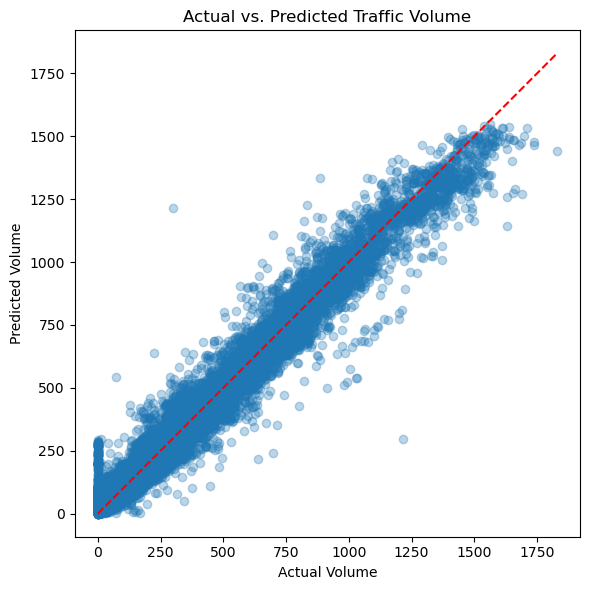

In [8]:
# Plot actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.title("Actual vs. Predicted Traffic Volume")
plt.tight_layout()
plt.show()

In [9]:
# TimeSeriesSplit Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(
    pipeline, X, y,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

rmse_scores = -cv_scores
print("\n[TimeSeriesSplit CV Evaluation]")
print("Fold RMSE scores:", rmse_scores)
print("Mean RMSE: {:.2f}".format(np.mean(rmse_scores)))
print("Standard Deviation: {:.2f}".format(np.std(rmse_scores)))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



[TimeSeriesSplit CV Evaluation]
Fold RMSE scores: [29.43806022 20.34886007 52.66371312 28.11722818 29.74700738]
Mean RMSE: 32.06
Standard Deviation: 10.86


RMSE in Context
Metric	Value
Average Volume (vol)	~150 vehicles
RMSE (Test set)	~30 vehicles
Relative RMSE	30 / 150 = 20% error rate
R²	0.9747
Dataset size	500,000+ rows